# read dicom

## reference
https://www.kaggle.com/randy19962/dicom

In [5]:
# !pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [1]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Read Dicom

In [2]:
def read_dicom(path):
    g = glob.glob(path + '/CT*.dcm')
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
    print('RescaleSlope :{}'.format(slices[0].RescaleSlope))
    print('SliceThickness :{}'.format(slices[0].SliceThickness))
    print('Pixel Spacing  :{}'.format(slices[0].PixelSpacing ))

    return slices

In [3]:
def show_raw_pixel(slices):
    #讀出像素值並且儲存成numpy的格式
    image = slices.pixel_array
    plt.figure(figsize = (12,12))
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

In [4]:
slices = read_dicom('data/20201110_CBCT加reg檔案/L224_GYN/20190308_CBCT')

RescaleIntercept :-1000
RescaleSlope :1
SliceThickness :1.98849010467529
Pixel Spacing  :[9.0802038e-1, 9.0802038e-1]


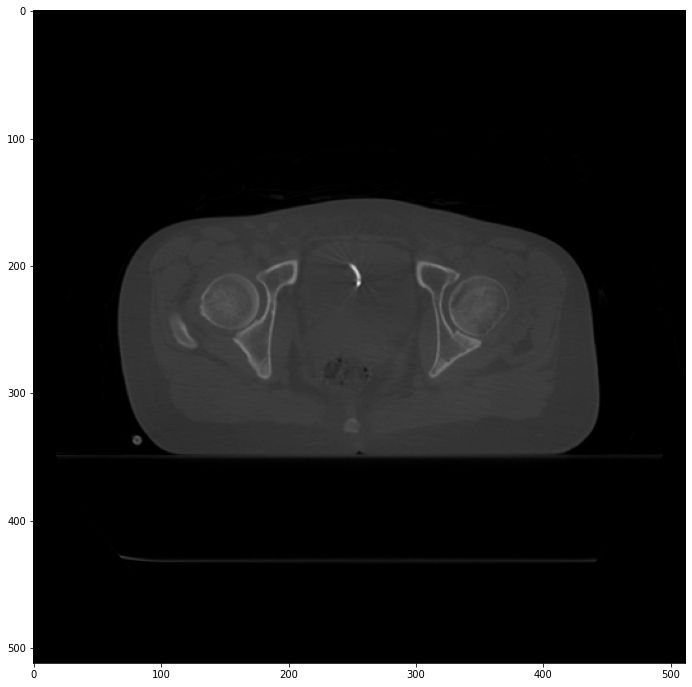

In [5]:
show_raw_pixel(slices[20])


In [6]:
#plot histogram

def show_raw_hist(slices):
    plt.hist(slices.pixel_array.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

RescaleIntercept :-1000
RescaleSlope :1
SliceThickness :1.98849010467529
Pixel Spacing  :[9.0802038e-1, 9.0802038e-1]


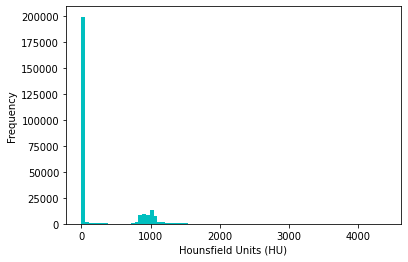

In [7]:
show_raw_hist(read_dicom('data/20201110_CBCT加reg檔案/L224_GYN/20190308_CBCT')[60])


# Get HU values

DICOM裡面每個像素儲存的值並不是直接就是HU，而是必須透過DICOM中的Rescale Intercept 和 Rescale Slope經過轉換公式來取得，公式如下  Outputunits=m×SV+b 
其中m 就是Rescale Slope，b就是Rescale Intercept，SV(stored values)就是每個pixel儲存的值。
有些CT的機器掃描出來的圖式圓形的，但是最後儲存的圖都是方形的，因此圖片中沒有資訊的部分，機器儲存的pixel值會比空氣還小很多(這個圖檔為-1000)。所以在轉換成HU之前，小於0的pixel值設定跟空氣一樣為0，轉換之後的HU就會跟空氣一樣是-1000 以下函式會計算出每個像素的HU

In [11]:
def get_pixels_hu(slices):
    #讀出像素值並且儲存成numpy的格式
    image = np.stack([s.pixel_array for s in slices])

    # 將超過機器掃描範圍的部分設為 0
    # 通常intercept是 -1024, 經過計算之後空氣大約是 0
    image[image < 0] = 0
    
    # 轉換為Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] = image[slice_number].astype(np.int16) + np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

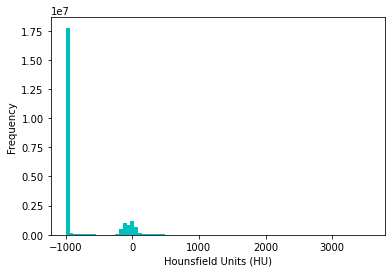

In [12]:
patient_pixels = get_pixels_hu(slices)
plt.hist(patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

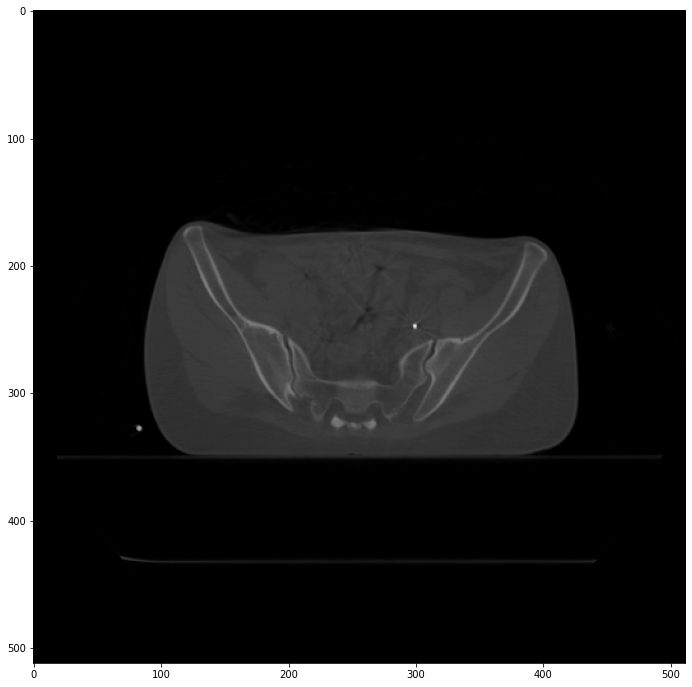

In [13]:
# Show some slice in the middle
plt.figure(figsize=(12,12))
plt.imshow(patient_pixels[60], cmap=plt.cm.gray)
plt.show()

# Resampling

## 面函式對原本的3維照片進行縮放，讓所有圖檔的spacing都變成 1mm×1mm×1mm

In [14]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    #取出原本的spacing
    #[scan[0].SliceThickness] + list(scan[0].PixelSpacing) 會組成一個list，裡面是的spacing數值
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float64)


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    #計算出放大參數後，用scipy對3為照片進行縮放，scipy會自動為圖片進行插補
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [15]:
import scipy.ndimage
image, new_spacing = resample(patient_pixels, slices)

In [14]:
new_spacing

array([0.99992645, 0.99979878, 0.99979878])

In [15]:
# after resampling, there might be more slices
image.shape

(175, 465, 465)

In [16]:
patient_pixels.shape

(88, 512, 512)

In [18]:
120 /image.shape[0]

0.6857142857142857

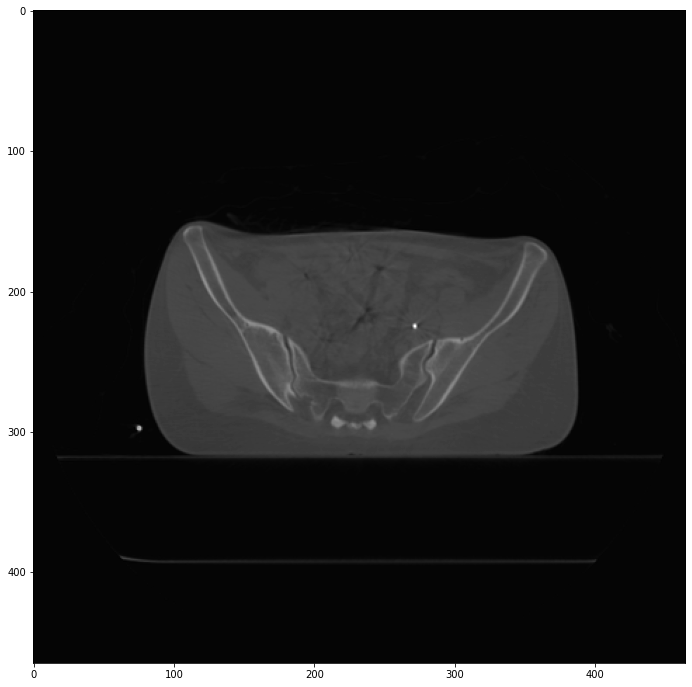

In [16]:
plt.figure(figsize=(12,12))
plt.imshow(image[120], cmap=plt.cm.gray)
plt.savefig('conebeam_ct.png')
plt.show()

# Window level

https://www.facebook.com/199733860383857/posts/490663181290922/

CT的深淺由CT number的大小來決定，然而CT number的跨越相當的廣，由空氣的-1000到骨頭的+1000，但人眼所能辨識的灰階數大約只有256種，在這種限制下，我們便會針對不同的需求，設計不同的Window Width(WW)和Window Level(WL)。
.
WL就像是中間值的概念，WW則是CT number橫跨的範圍，舉例來說，當設定WL=40, WW=400時，我們所看到的範圍將在-160~240之間，小於-160的就是全黑而大於240則是全白，如此一來，根據不同的部位就會有不同的設定值，像是Lung window , Bone window…..等等。

In [ ]:
# brain W:80 L:40
# subdural W:130-300 L:50-100
# stroke W:8 L:32 or W:40 L:40 3
# temporal bones W:2800 L:600
# soft tissues: W:350–400 L:20–60 4
# chest
# lungs W:1500 L:-600
# mediastinum W:350 L:50
# abdomen
# soft tissues W:400 L:50
# liver W:150 L:30
# spine
# soft tissues W:250 L:50
# bone W:1800 L:400

In [31]:
def hu_window(scan, window_level=40, window_width=80):
    window = [window_level-window_width, window_width-window_level]
    scan[scan < window[0]] = window[0]
    scan[scan > window[1]] = window[1]

    plt.figure(0, figsize=(12,12))
    plt.imshow(scan, cmap=plt.cm.gray)

    plt.figure(1, figsize=(6,6))
    plt.hist(scan.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()


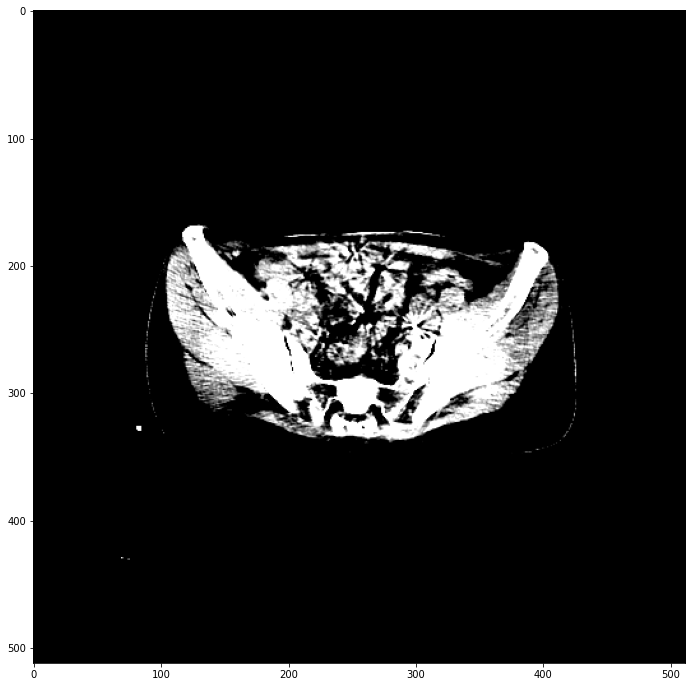

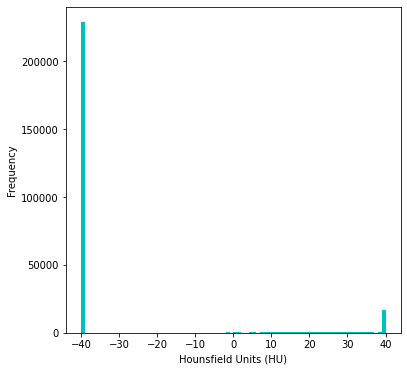

In [32]:
hu_window(patient_pixels[60])

# 3D

In [109]:
import skimage.measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def plot_3d(image, threshold):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values  = skimage.measure.marching_cubes_lewiner(p, threshold)


    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [20]:
# skimage.measure.label
# plot_3d(image, 400)

In [23]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized